In [1]:
import torch

In [2]:
### Select device (GPU) ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'


print('Selected device:', device)

Selected device: cuda


In [3]:
import pandas as pd
from ast import literal_eval

### Reading Tokens ###

df = pd.read_csv(
    '../data-sets/Zinparen in Engels-Nederlands - 2024-06-07_tokens.csv',
    names=['ENG_TOKENS', 'NLD_TOKENS'],
    converters={ 'ENG_TOKENS': literal_eval, 'NLD_TOKENS': literal_eval})


df

,ENG_TOKENS,NLD_TOKENS
0,"[<sos>, Let, 's, try, something, ., <eos>]","[<sos>, Laten, we, iets, proberen, !, <eos>]"
1,"[<sos>, Let, 's, try, something, ., <eos>]","[<sos>, Laat, ons, iets, proberen, ., <eos>]"
2,"[<sos>, I, have, to, go, to, sleep, ., <eos>]","[<sos>, Ik, moet, gaan, slapen, ., <eos>]"
3,"[<sos>, Today, is, June, 18th, and, it, is, Mu...","[<sos>, Vandaag, is, het, 18, juni, en, het, i..."
4,"[<sos>, Muiriel, is, 20, now, ., <eos>]","[<sos>, Muiriel, is, nu, 20, jaar, oud, ., <eos>]"
...,...,...
155192,"[<sos>, Cotton, candy, is, usually, sold, and,...","[<sos>, Suikerspinnen, worden, gewoonlijk, ver..."
155193,"[<sos>, At, the, moment, I, am, looking, for, ...","[<sos>, Op, het, moment, ben, ik, op, zoek, na..."
155194,"[<sos>, The, unthinkable, happened, ., <eos>]","[<sos>, Het, ondenkbare, is, gebeurd, ., <eos>]"
155195,"[<sos>, Let, 's, wait, until, she, rings, ., <...","[<sos>, Laten, we, wachten, tot, ze, belt, !, ..."


In [4]:
### Filtering and splitting tokens ###

train_frac = 0.9
max_size = 20

def filter_rows(row):
        return len(row['ENG_TOKENS']) <= max_size and len(row['NLD_TOKENS']) <= max_size

df = df[df.apply(filter_rows, axis=1)]

# Split
df = df.sample(frac=1).reset_index(drop=True)
split = int(train_frac * len(df))

train_data = df.iloc[:split, :]
test_data  = df.iloc[split:, :]
test_data.reset_index(drop=True, inplace=True)


print('Total rows from file:', len(df))
print('Total rows of train data:', len(train_data))
train_data

Total rows from file: 153300
Total rows of train data: 137970


,ENG_TOKENS,NLD_TOKENS
0,"[<sos>, Where, 's, Sven, from, ?, "", Copenhage...","[<sos>, '', Waar, komt, Sven, vandaan, ?, '', ..."
1,"[<sos>, Sami, thought, that, the, imam, was, t...","[<sos>, Sami, dacht, dat, de, imam, over, hem,..."
2,"[<sos>, Who, knows, the, answers, ?, <eos>]","[<sos>, Wie, weet, de, antwoorden, ?, <eos>]"
3,"[<sos>, I, can, not, respect, Tom, ., <eos>]","[<sos>, Ik, kan, Tom, niet, respecteren, ., <e..."
4,"[<sos>, Be, quiet, !, <eos>]","[<sos>, Wees, stil, ., <eos>]"
...,...,...
137965,"[<sos>, I, 'll, get, you, some, coffee, ., <eos>]","[<sos>, Ik, breng, je, wat, koffie, ., <eos>]"
137966,"[<sos>, Well, done, ., <eos>]","[<sos>, Chapeau, !, <eos>]"
137967,"[<sos>, Tom, hypnotized, me, ., <eos>]","[<sos>, Tom, hypnotiseerde, me., <eos>]"
137968,"[<sos>, Tom, constantly, contradicts, himself,...","[<sos>, Tom, spreekt, zichzelf, voortdurend, t..."


In [5]:
import itertools

import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import build_vocab_from_iterator

### Build vocabularies ###

min_freq  = 4
unk_token = '<unk>'
pad_token = '<pad>'
sos_token = '<sos>'
eos_token = '<eos>'

special_tokens = [unk_token, pad_token, sos_token, eos_token]


eng_vocab = build_vocab_from_iterator(
    itertools.chain(train_data['ENG_TOKENS'], test_data['ENG_TOKENS']),
    min_freq=min_freq,
    specials=special_tokens
)


nld_vocab = build_vocab_from_iterator(
    itertools.chain(train_data['NLD_TOKENS'], test_data['NLD_TOKENS']),
    min_freq=min_freq,
    specials=special_tokens
)

eng_vocab.set_default_index(eng_vocab[unk_token])
nld_vocab.set_default_index(nld_vocab[unk_token])


print('Unique tokens in \'eng_tokens\' column:', len(eng_vocab))
print('Unique tokens in \'nld_tokens\' column:', len(nld_vocab))

Unique tokens in 'eng_tokens' column: 8477
Unique tokens in 'nld_tokens' column: 9827


In [6]:
import numpy as np

### Vectorize tokens ###

eng_pad_index = eng_vocab[pad_token]
nld_pad_index = nld_vocab[pad_token]


def build_dataset(subset):
    X = np.zeros((len(subset), max_size), dtype=np.int32)
    Y = np.zeros((len(subset), max_size), dtype=np.int32)
        
    for ix, row in subset.iterrows():
        eng_ixs = eng_vocab.lookup_indices(row['ENG_TOKENS'])
        eng_ixs = eng_ixs + [eng_pad_index] * (max_size - len(eng_ixs))

        nld_ixs = nld_vocab.lookup_indices(row['NLD_TOKENS'])
        nld_ixs = nld_ixs + [nld_pad_index] * (max_size - len(nld_ixs))

        X[ix] = eng_ixs
        Y[ix] = nld_ixs

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)


import random

print('Xtr shape:', Xtr.shape)
print()
print('Random vector:')
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))


Xtr shape: torch.Size([137970, 20])

Random vector:
[2, 5, 61, 501, 10, 7, 8, 962, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 5, 1757, 45, 143, 37, 12, 1301, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

['<sos>', 'I', "'ll", 'drive', 'you', 'to', 'the', 'airport', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'Ik', 'breng', 'u', 'wel', 'naar', 'het', 'vliegveld', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
### Bidirection Encoder ###

class Encoder(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers=1, dropout=0):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_layers

        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)

        self.dropout     = nn.Dropout(dropout)

    
    def forward(self, input):
        ''' The input of the encoder is a matrix of vectorized tokens in a shape of batch size * sequence length '''
        # input = [N, L]

        batch_size = input.shape[0] # N

        ''' Get learnable multi-dimensional embeddings of the input matrix '''
        embeddings = self.dropout(self.embeddings(input))
        # embeddings = [N, L, embedding dim]

        ''' Run the embeddings through an RNN, iterating over the `sequence length` dimension '''
        output, hidden = self.rnn(embeddings)
        # output = [N, L, 2 * hidden size]
        # hidden = [2 * num layers, N, hidden size]

        '''  Concat hidden states of forward and backward passes to obtain the annotations '''
        hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_size) # [num layers, 2, N, hidden size]
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)    # [num layers, N, 2 * hidden size]

        '''
         * Encoder outputs: Sequence of (the sum of) hidden states from the encoder for each time step.
         * Hidden state:    The last hidden state from the encoder, which can be used to initialize the decoder's hidden state.
        '''
        return output, hidden


In [9]:
### Bahdanau Attention mechanism ###

''' The attention determines which part of the input (encodings) is relevant for the current decoder's hidden state '''

class Attention(nn.Module):

    def __init__(self, num_layers, hidden_size):
        super(Attention, self).__init__()

        self.W1 = nn.Linear(num_layers * hidden_size, hidden_size)
        self.W2 = nn.Linear(2*hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    
    def forward(self, hidden, encodings):
        ''' The decoder's hidden state is also known as the 'Query', and the encoder's outputs as the 'Values' '''
        # hidden    = [num layers, N, hidden size]
        # encodings = [N, L, 2 * hidden size]

        hidden = torch.movedim(hidden, 0, 1)
        # hidden = [N, num layers, hidden size]

        batch_size =  hidden.shape[0] # N
        num_layers =  hidden.shape[1]
        hidden_size = hidden.shape[2]

        concat_hidden = hidden.reshape(batch_size, num_layers * hidden_size)
        # concat_hidden = [N, num layers * hidden size]

        concat_hidden = concat_hidden.unsqueeze(1) # add a dimension to match the encodings
        # concat_hidden = [N, 1, num layers * hidden size]

        ''' Calculate scores '''
        scores = self.V(torch.tanh(self.W1(concat_hidden) + self.W2(encodings)))
        # scores = [N, L, 1]

        scores = torch.movedim(scores, 1, 2)
        # scores = [N, 1, L]

        ''' Rescale so that the scores lie in the range of [0-1] and sum to 1. '''
        attention_weights = F.softmax(scores, dim=-1)
        # attention_weights = [N, 1, L]

        ''' Calculate the context vector '''
        context_vector = torch.bmm(attention_weights, encodings)
        # context_vector = [N, 1, 2 * hidden size]

        context_vector = context_vector.squeeze(1)
        attention_weights = attention_weights.squeeze(1)
        # context_vector = [N, 2 * hidden size]
        # attention_weights = [N, L]

        return  context_vector, attention_weights

In [10]:
### Decoder ###

class Decoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers=1, dropout=0):
        super(Decoder, self).__init__()

        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size

        self.attention   = Attention(num_layers, hidden_size)
        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim + hidden_size*2, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc          = nn.Linear(hidden_size, vocab_size)

        self.dropout     = nn.Dropout(dropout)

    
    def forward(self, input, hidden, encodings):
        # input     = [N]
        # hidden    = [num layers, N, hidden size]
        # encodings = [N, L, 2 * hidden size]

        ''' Get learnable multi-dimensional embeddings of the input '''
        embeddings = self.dropout(self.embeddings(input))
        # embeddings = [N, embedding dim]

        ''' Recompute context vector every time step, using the hidden state of the last RNN layer and the encoder outputs '''
        context_vector, att_weights = self.attention(hidden, encodings)
        # context_vector = [N, hidden size * 2]
        # att_weights    = [N, L]

        ''' Join the embeddings with the context vector as input for the decoder RNN '''
        rnn_input = torch.cat((embeddings, context_vector), dim=1)
        # rnn_input = [N, embedding dim + 2 * hidden size]

        rnn_input = rnn_input.unsqueeze(1) # Add a `sequence length` dimension
        # rnn_input = [N, 1, embedding dim + 2 * hidden size]

        ''' Run the joined input through an RNN, iterating only one step '''
        output, hidden = self.rnn(rnn_input, hidden)
        # output = [N, 1, hidden size]
        # hidden = [num layers, N, hidden size]

        output = output.squeeze(1) # Remove the `sequence length` dimension
        # output = [N, hidden size]

        ''' Make a prediction for the next token '''
        prediction = self.fc(output)
        # prediction = [N, vocab size]

        return prediction, hidden, att_weights

In [11]:
### Sequence to sequence model ###

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.fc_hidden = nn.Linear(encoder.hidden_size*2, decoder.hidden_size)
    
    
    def forward(self, source, target, forced_teaching_ratio=0):
        # source = [N, L]
        # target = [N, L]

        batch_size        = target.shape[0] # N
        sequence_length   = target.shape[1] # L
        target_vocab_size = self.decoder.vocab_size


        ''' Encode the whole input sequence using the encoder '''
        encodings, hidden = self.encoder(source)
        # encodings = [N, L, 2 * hidden size]
        # hidden    = [num layers, N, 2 * hidden size]


        ''' Compute initial hidden state for the decoder based on the encoder's last hidden state '''
        hidden = torch.tanh(self.fc_hidden(hidden))
        # hidden = [num layers, N, hidden size]

        ''' Create a primer for the Decoder '''
        input = target[:, 0] # first input to the decoder is the <sos> tokens
        # input = [N]

        ''' Create a tensor to save the results to '''
        outputs = torch.zeros(sequence_length, batch_size, target_vocab_size).to(device)
        # outputs = [L, N, vocab size]
        

        ''' Generate a single new token every iteration, parallel for all batches '''
        for i in range(1, sequence_length):

            ''' Decode the next output in the sequence with the previously generated token as input '''
            output, hidden, _ = self.decoder(input, hidden, encodings)
            # output = [N, vocab size]
            # hidden = [num layers, N, 2 * hidden size]

            outputs[i] = output # Save generated output in a new dimension
            
            ''' Determine next input token for the decoder, possibly using forced teaching '''
            if random.random() < forced_teaching_ratio:
                input = target[:, i] # ground truth token
            else:
                input = torch.argmax(output, dim=1)
        
        outputs = outputs.permute(1, 2, 0) # Shuffle dimensions around to match what the criterion wants
        # outputs = [N, vocab size, L]
        
        return outputs


    @torch.inference_mode()
    def evaluate(self, tokens, max_output_length=20):
        self.eval()
        
        ixs = eng_vocab.lookup_indices(tokens)

        tensor = torch.tensor(ixs).to(device)
        # tensor = [L]

        tensor = tensor.unsqueeze(0) # Add a single batch dimension
        # tensor = [1, L]

        ''' Encode whole input sequence using the encoder '''
        encodings, hidden = self.encoder(tensor)
        # encodings = [1, L, 2 * hidden size]
        # hidden = [num layers, 1, 2 * hidden size]

        ''' Compute initial hidden state for the decoder based on the encoder's last hidden state '''
        hidden = torch.tanh(self.fc_hidden(hidden))

        ''' Create a primer for the Decoder '''
        indices = [nld_vocab[sos_token]] # first input to the decoder is the <sos> tokens
        
        attentions = []
        for _ in range(max_output_length):
            ''' Decode with the previous generated index as input '''
            inputs_tensor = torch.tensor(indices[-1]).unsqueeze(0).to(device)
            output, hidden, attention = self.decoder(inputs_tensor, hidden, encodings)
            # output =    [1, vocab size]
            # hidden =    [num layers, 1, 2 * hidden size]
            # attention = [1, L]

            output = output.squeeze(0)
            # output = [vocab size]

            prediction = torch.argmax(output).item()
            
            indices.append(prediction)
            attentions.append(attention)
            
            ''' Stop generating when End Of Sequence token is generated '''
            if(prediction == nld_vocab[eos_token]):
                break
        
        tokens = nld_vocab.lookup_tokens(indices) # Convert indices back to tokens
        attentions_tensor = torch.cat(attentions)
        # attentions_tensor = [L (out) - 1, L (in)]

        return tokens, attentions_tensor

#### Wide vs Deep network

Wide, shallow networks are very good at memorization, but not so good at generalization. If you train the network with every possible input value, a super wide network could eventually memorize the corresponding output value that you want. The advantage of multiple layers is that they can learn features at various levels of abstraction. Multiple layers are much better at generalizing because they learn all the intermediate features between the raw data and the high-level expected output?. Vanishing and exploding gradients are however a problem to look out for.

#### Dropout considerations

Dropout is the probability of ignoring some layer outputs during trainig. This will prevent overfitting because the network cannot overly rely on specific connections. This will however come at the cost of longer training times.

In [12]:
# Initiate neural network

emb_dim     = 300
hidden_size = 350
num_layers  =   3
dropout     = 0.55


encoder = Encoder(len(eng_vocab), emb_dim, hidden_size, num_layers=num_layers, dropout=dropout)
decoder = Decoder(len(nld_vocab), emb_dim, hidden_size, num_layers=num_layers, dropout=dropout)
model   = Seq2Seq(encoder, decoder).to(device)


print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 18480777


In [13]:
import os.path

if os.path.isfile('../models/RNN-Attention_11-06-2024.pt'):
    print('Found saved state dictionary!')
    model.load_state_dict(torch.load('../models/RNN-Attention_11-06-2024.pt'))

#### Forced teaching

Forced teaching is a method to train recurrent neural networks more quickly and efficiently by providing the ground thruth from a prior time step as input instead of its own generated output.

During inference, there is no ground thruth and the model will use its own previous output as input, so there is a difference between training and inference, which might lead to poor model performance. To prevent this we gradually reduce the forced teaching ratio throughout the training to zero.

In [14]:
# learning_rate = 0.00015 # Tested for batch size of 32 & 64
learning_rate = 0.00035 # Tested for batch size of 128
weight_decay  = 0.0001 # L2 regularization
step_size     = 50000 # Period of learning rate decay
gamma         = 0.1 # Multiplicative factor of learning rate decay


def forced_teaching_ratio(current_epoch, total_epochs, initial_ratio=0.9, final_ratio=0):
    progress = current_epoch / total_epochs
    return initial_ratio - (initial_ratio - final_ratio) * progress


criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # Learning rate scheduler

In [15]:
def log_statistics(eval_batch_size=64):

    inputs = torch.zeros((eval_batch_size, max_size), dtype=torch.long).to(device)
    inputs[:, 0] = nld_vocab[sos_token]

    model.eval()
    with torch.inference_mode():
    
        # Sample the models performence on a subset of training data
        ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,))
        Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)
        
        outputs = model(Xb, inputs)
        train_loss = F.cross_entropy(outputs, Yb)


        # Sample the models performence on a subset of testing data
        ix = torch.randint(0, Xte.shape[0], (eval_batch_size,))
        Xb, Yb = Xte[ix].to(device), Yte[ix].to(device)

        outputs = model(Xb, inputs)
        test_loss = F.cross_entropy(outputs, Yb)
        
        
        return train_loss.item(), test_loss.item()

#### Batch size considerations

Increasing the BS will accelerate training by making more efficient use of hardware, and increasing stability. With smaller datasets however, it will overfit faster, because learning is happening on a more similair set of samples.

Decreasing the BS allows the network to generalise better and avoids local minima early at training, This is because a low BS inherently introduces instability and moves the gradient around more, which allows you to escape local minima.

Changing the batch size will affect how high the learning rate should be. A rule of thumb is to double the learning rate as you double the batch size.

In [16]:
from tqdm import trange

### Train network ###

epoch_count       = []
train_loss_values = []
test_loss_values  = []
learning_rates    = []

iterations        = 175000
batch_size        =    128


for i in trange(iterations):
    model.train()
    ft_ratio = forced_teaching_ratio(i, iterations)

    ''' Sample mini-batch and send to gpu '''
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

    ''' Perform a single training iteration '''
    output = model(Xb, Yb, ft_ratio) # Do the forward pass
    loss = criterion(output, Yb)     # Calculate the loss
    optimizer.zero_grad()            # Reset parameters
    loss.backward()                  # Backpropagation
    optimizer.step()                 # Update parameters
    scheduler.step()                 # Step the scheduler

    ''' Report progression every so often '''
    if ((i + 1) % (iterations / 50) == 0):
        train_loss, test_loss = log_statistics(batch_size)

        epoch_count.append(i) # Visualize
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        learning_rates.append(scheduler.get_last_lr())


''' Determine model's performance based on a larger subset '''
train_loss, test_loss = log_statistics(2*batch_size)

epoch_count.append(i) # Visualize
train_loss_values.append(train_loss)
test_loss_values.append(test_loss)
learning_rates.append(scheduler.get_last_lr())

 
# Print final results
print()
print('Final training loss:', round(train_loss, 3))
print('Final test loss:    ', round(test_loss, 3))

  1%|          | 954/175000 [02:20<7:10:30,  6.74it/s]

In [ ]:
torch.save(model.state_dict(), '../models/RNN-Attention_14-06-2024.pt')

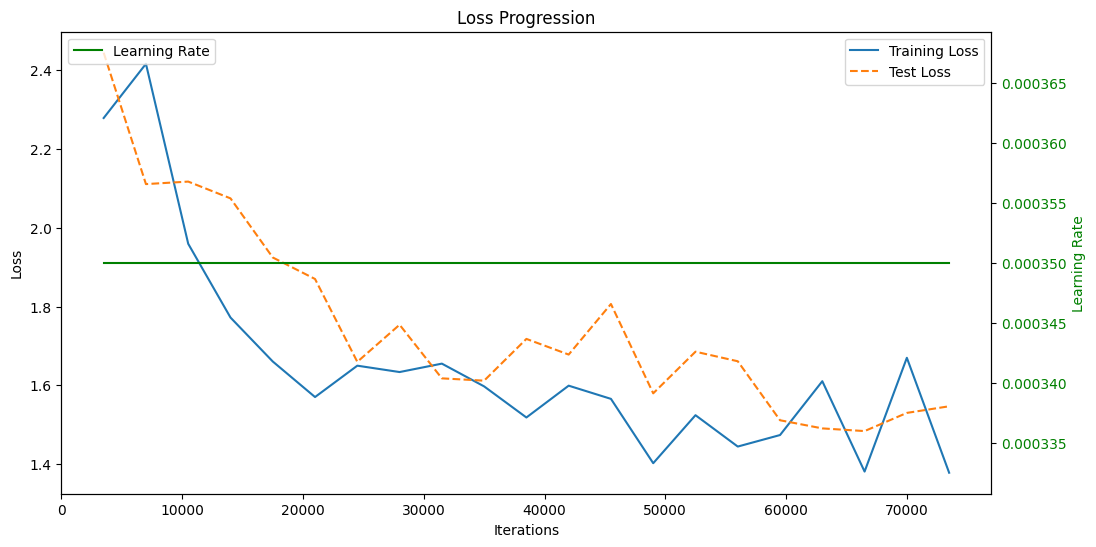

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and the primary y-axis
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot the loss on the primary y-axis
ax1.plot(epoch_count, train_loss_values, label='Training Loss')
ax1.plot(epoch_count, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')

# Create the secondary y-axis for the learning rate
ax2 = ax1.twinx()
ax2.plot(epoch_count, learning_rates, label='Learning Rate', color='green')
ax2.set_ylabel('Learning Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends to each y-axis
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')

# Show the plot
plt.show()

In [ ]:
import spacy

# spacy.cli.download("en_core_web_sm")
# spacy.cli.download("nl_core_news_sm")

nlp_en = spacy.load("en_core_web_sm")
nlp_nl = spacy.load("nl_core_news_sm")

def tokenize_spacy(sentence):
    tokens = [token.text for token in nlp_en(sentence)]
    return [sos_token] + tokens + [eos_token]

In [ ]:
import re

def translate(sentence, max_output_length=20):
    tokens = tokenize_spacy(sentence)

    tokens, _ = model.evaluate(tokens, max_output_length)

    tokens = [t for t in tokens if t not in (eos_token, sos_token)]
    new_sentence = ' '.join(tokens).capitalize()
    new_sentence = re.sub(r'\s+([.,!?])', r'\1', new_sentence)

    return new_sentence

In [ ]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


<unk>!
Het is niet goed.
Ik ben vandaag erg gelukkig vandaag.
Hij is erg <unk>.
Die man draagt een witte hemd.
Hij is erg bang voor spinnen.
Hij gaat naar naar zijn naar..
Die gaan gaan naar werk werk. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ik ga vandaag niet met je met.
Mijn vriendin komt niet niet..
Hij kocht een cadeau voor voor cadeau voor.. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def evaluateAndShowAttention():

    ''' Sample a random sentence from the test data '''
    input_tokens = test_data.sample()['ENG_TOKENS'].iloc[0]

    output_tokens, attentions = model.evaluate(input_tokens)

    output_tokens = output_tokens[1:] # Remove single batch dimension

    attentions = attentions.cpu().numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)
                       
    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    plt.show()

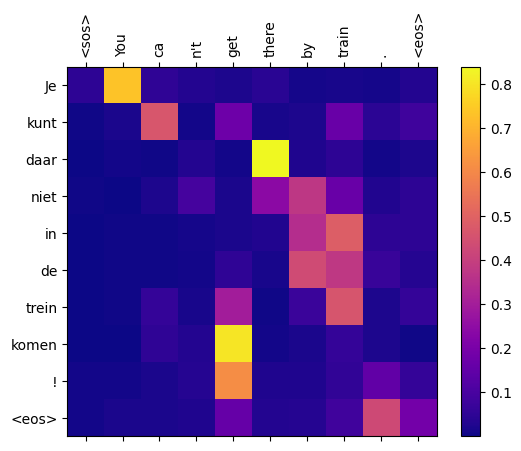

In [ ]:
evaluateAndShowAttention()